## 1   导入相关模块

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import shutil
import random
import pandas as pd
import numpy as np
import gc
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, InceptionV3, VGG16,DenseNet201,VGG19
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, \
    BatchNormalization, GlobalAveragePooling2D, Input, Flatten
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
import keras.backend.tensorflow_backend as KTF

import tensorflow.keras.preprocessing.image as image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import glob
import re
from datetime import datetime

Using TensorFlow backend.


### 1.1 指定显卡，设置tensorflow按照需求占用GPU（训练过程会出现溢出的情况，应该是cuda版本问题）

In [2]:
# 指定显卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.Session(config=config)
KTF.set_session(session)

plt.rcParams['font.sans-serif'] = ['SimHei'] #设置字体（个人电脑原因）

### 1.2 回调函数及图片读取函数,后面会用到

In [3]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
        self.vallosses = []
        self.valaccuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))

    def on_epoch_end(self, epoch, logs={}):
        self.vallosses.append(logs.get('val_loss'))
        self.valaccuracies.append(logs.get('val_acc'))

In [4]:
def get_batches(path=r"/home/xiaolin/", batch_size=32, target_size=(224, 224), class_mode="binary",
                preprocessing_function=preprocess_input, data_aug=True):
    """
    create data generator，key parameters：
    data_aug:whether create augmentation dataset
    preprocessing_fuction：preprocessing
    return value：
    train_gen：train dataset
    train_gen_aug：train dataset with augumentation
    valid_gen：valid dataset
    test_gen：test set
    """
    print("Reading train dataset")
    data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    train_gen = data_gen.flow_from_directory(path + "train", seed=1, target_size=target_size,
                                             shuffle=True, class_mode=class_mode, batch_size=batch_size)
    print("Reading valid dataset")
    data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    valid_gen = data_gen.flow_from_directory(path + "valid", seed=1, target_size=target_size,
                                             shuffle=True, class_mode=class_mode, batch_size=batch_size)
    print("Reading test dataset")
    data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    test_gen = data_gen.flow_from_directory(path + "test", seed=1, target_size=target_size,
                                            shuffle=False, class_mode=None, batch_size=batch_size)
    if data_aug:
        print("augmentation（rotation、shift） train set")
        data_gen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=10,
                                      width_shift_range=0.15,
                                      height_shift_range=0.15)
        train_gen_aug = data_gen.flow_from_directory(path + "train", seed=1, target_size=target_size,
                                                     shuffle=True, class_mode=class_mode, batch_size=batch_size)
        return train_gen, train_gen_aug, valid_gen, test_gen
    else:
        return train_gen, valid_gen, test_gen


def get_test_batches(path=r"/home/xiaolin/", batch_size=32, target_size=(224, 224), class_mode="binary",
                     preprocessing_function=preprocess_input):
    print("Reading test dataset")
    data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    test_gen = data_gen.flow_from_directory(path + "test", seed=1, target_size=target_size,
                                            shuffle=False, class_mode=None, batch_size=batch_size)
    return test_gen

def read_image_target_size(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    #     x = np.expand_dims(x, axis=0)
    return img

## 2 分割训练集:按照司机ID,随机分割
<font color=red>已在IDE中划分好(按照司机ID)，因此未在Jupyter中未调用划分程序</font>

In [5]:
import glob
train_path = r"/home/xiaolin/train"
driver_path = r"/home/xiaolin"
def create_valid_byid(train_path,driver_path):
    
    file_pathes = []
    driver_path = os.path.join(path, 'driver_imgs_list.csv')
    driver_list = pd.Series(data = pd.read_csv(driver_path,usecols=["img"]).img)

    for j in range(10):
        print('Load folder c{}'.format(j))
        path_sc = os.path.join(train_path, 'c' + str(j), '*.jpg')
        # get data string
        files = glob.glob(os.path.join(path_sc))
        file_pathes += files
    file_names = [os.path.basename(i) for i in file_pathes]

    name_pathes = pd.Series(index = file_names,data=file_pathes)
    for i in range(3000):
        data = driver_list.iloc[i]
        print(data)
        
        if data in file_names:
            if not os.path.exists(os.path.dirname(re.sub(r"train","valid",name_pathes[data]))):
                os.makedirs(os.path.dirname(re.sub(r"train","valid",name_pathes[data])))
            shutil.move(t[data],re.sub(r"train","valid",name_pathes[data]))
        else:
            print("源文件不存在，请确认是否已经复制完成，还是文件丢失")
            
def create_shuffled_valid():
    """create random shuffled validation set"""
    train_path = r"/home/xiaolin/train"
    valid_path = r"/home/xiaolin/valid"
    train_dir = os.listdir(path=r"/home/xiaolin/train")

    for i in train_dir:
        class_dir = os.listdir(train_path + "/" + i)
        random.shuffle(class_dir)
        for j in class_dir[:int(len(class_dir) * 0.15)]:
            os.makedirs(valid_path + "/" + i, exist_ok=True)
            shutil.copyfile(train_path + "/" + i + "/" + j, valid_path + "/" + i + "/" + j)
            os.remove(train_path + "/" + i + "/" + j)
            
def get_test_result(model, test_gen, classes=True, filename="submission.csv",dir_name="vgg"):
    """get result with Dataframe format and save to csv file"""
    result_predict = model.predict_generator(test_gen)
    file_names = [re.search(r"img.+\.jpg", i).group(0) for i in test_gen.filenames]
    predict_classes = np.argmax(result_predict, -1)

    result = pd.DataFrame(file_names, columns=["img"])
    result_pro = pd.DataFrame(result_predict, columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])

    result_csv = result.join(result_pro)
    if classes:
        result_csv = result_csv.join(pd.DataFrame(predict_classes, columns=["classes"]))
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    result_csv.to_csv("./"+dir_name+"/"+filename)

    return result_csv

### 2.1  交叉验证集数据存储

In [6]:
def get_driver_data(path="/home/xiaolin"):
    dr = dict()
    path = os.path.join(path, 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [7]:
def load_train_data(path="/home/xiaolin/", target_size=(224, 224),preprocessing_function=preprocess_input):
    """load train data with target size and subtracting the mean value"""
    x_train = []
    y_train = []
    driver_id = []
    filenames = []
    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path_sc = os.path.join(path, 'train', 'c' + str(j), '*.jpg')
        # get data string
        files = glob.glob(os.path.join(path_sc))
        for fl in files:
            flbase = os.path.basename(fl)
            y_train.append(j)
            driver_id.append(driver_data[flbase])
        filenames += files

    data = list(zip(driver_id, filenames, y_train))
    data = sorted(data, key=lambda x: x[0])
    driver_id, filenames, y_train = zip(*data)

    j = 1
    length = len(filenames)
    for i in filenames:
        img = read_image_target_size(i, target_size)
        img = preprocessing_function(img)
        x_train.append(img)
        j = j + 1
        print("\r The program has processed {:.0f}%".format(j * 100 / length), end="")
    x_train = np.array(x_train)
    y_train = np.array(to_categorical(y_train))
    return x_train, y_train

In [8]:
def save_data(dir_name="preprocess_data",preprocessing_function=preprocess_input):
    """save image with target size and subtracting the mean value as npy data"""
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    train_x, train_y = load_train_data(preprocessing_function=preprocessing_function)
    np.save("./{}/train_x.npy".format(dir_name), train_x)
    np.save("./{}/train_y.npy".format(dir_name), train_y)


def load_npy_data(dir_name="preprocess_data"):
    """load preprocessed image data"""

    train_x = np.load("./{}/train_x.npy".format(dir_name))
    train_y = np.load("./{}/train_y.npy".format(dir_name))
    return train_x, train_y

# 3  图片预处理

In [9]:
def preprocess_box(x):
    """Preprocesses a Numpy array encoding a batch of images.
    # Returns
        Preprocessed Numpy array.
    """
    x1 = cv2.rectangle(x,(20,20),(120,120),(255,0,0),2)
    x1 = cv2.rectangle(x1,(210,100),(224,224),(255,0,0),2)
    x = np.array(x1)
    x /=125
    x -=1

    return x

def preprocess_mean_input(x):
    """Preprocesses a Numpy array encoding a batch of images.
    # Returns
        Preprocessed Numpy array.
    """
    mean_pixel = [123.68, 116.799, 103.939]
    x[:, :, 0] = x[:, :, 0] - mean_pixel[0]
    x[:, :, 1] = x[:, :, 1] - mean_pixel[1]
    x[:, :, 2] = x[:, :, 2] - mean_pixel[2]

    return x

def preprocess_scaling_input(x):
    """Preprocesses a Numpy array encoding a batch of images.
    # Returns
        Preprocessed Numpy array.
    """
    x /=125
    x -=1

    return x

def preprocess_edge_gray_input(x):
    """Preprocesses a Numpy array encoding a batch of images.
     Returns
        Preprocessed Numpy array.
    """
#     print("边缘检测图片1")
    img_x = cv2.Sobel(x,cv2.CV_16S,1,0)
    img_y = cv2.Sobel(x,cv2.CV_16S,0,1)
    img_x = cv2.convertScaleAbs(img_x)   # 转回uint8
    img_y = cv2.convertScaleAbs(img_y) 
    img = cv2.addWeighted(img_x,0.5,img_y,0.5,0)
    img1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY, img)
    
    img2 = cv2.Canny(np.squeeze(x).astype(np.uint8),10,100)
    img3 = np.array(x).copy()
    img3 = cv2.cvtColor(img3,cv2.COLOR_RGB2GRAY,img3)
    
    img = np.stack([img1,img2,img3],axis=-1)
    
    img = np.dot(img,0.008) - 1

    return img

def preprocess_edge_input(x):
    """Preprocesses a Numpy array encoding a batch of images.
     Returns
        Preprocessed Numpy array.
    """
#     print("边缘检测图片2")
    img_x = cv2.Sobel(x,cv2.CV_16S,1,0)
    img_y = cv2.Sobel(x,cv2.CV_16S,0,1)
    img_x = cv2.convertScaleAbs(img_x)   # 转回uint8
    img_y = cv2.convertScaleAbs(img_y) 
 
    img1 = cv2.cvtColor(img_x, cv2.COLOR_RGB2GRAY, img_x)
    img2 = cv2.cvtColor(img_y, cv2.COLOR_RGB2GRAY, img_y)
    img3 = cv2.Canny(np.squeeze(x).astype(np.uint8),10,100)

    
    img = np.stack([img1,img2,img3],axis=-1)
    
    img = np.dot(img,0.008) - 1

    return img

### 3.1  交叉验证集数据存储

In [10]:
def get_driver_data(path="/home/xiaolin"):
    dr = dict()
    path = os.path.join(path, 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [11]:
def load_train_data(path="/home/xiaolin/", target_size=(224, 224)):
    """load train data with target size and subtracting the mean value"""
    x_train = []
    y_train = []
    driver_id = []
    filenames = []
    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path_sc = os.path.join(path, 'train', 'c' + str(j), '*.jpg')
        # get data string
        files = glob.glob(os.path.join(path_sc))
        for fl in files:
            flbase = os.path.basename(fl)
            y_train.append(j)
            driver_id.append(driver_data[flbase])
        filenames += files

    data = list(zip(driver_id, filenames, y_train))
    data = sorted(data, key=lambda x: x[0])
    driver_id, filenames, y_train = zip(*data)

    j = 1
    length = len(filenames)
    for i in filenames:
        img = read_image_target_size(i, target_size)
        img = pre
        x_train.append(img)
        j = j + 1
        print("\r The program has processed {:.0f}%".format(j * 100 / length), end="")
    #         if j>1000:
    #             break
    x_train = np.array(x_train)
    y_train = np.array(to_categorical(y_train))
    return x_train, y_train


### 3.2 图片预处理可视化

In [12]:
def image_generator(path=r"/home/xiaolin", target_size=(224, 224)):
    file_path=[]
    i = 0
    for j in range(10):
        path_re = os.path.join(path, 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path_re)
        file_path+=files
        
    file_path = sorted(file_path)
    np.random.shuffle(file_path)
    while(i<len(file_path)):
        img = read_image_target_size(file_path[i])
        img = np.expand_dims(img,0)
        yield img
        i = i+1

### 3.3  预处理之增加边框

In [13]:
images = image_generator()

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


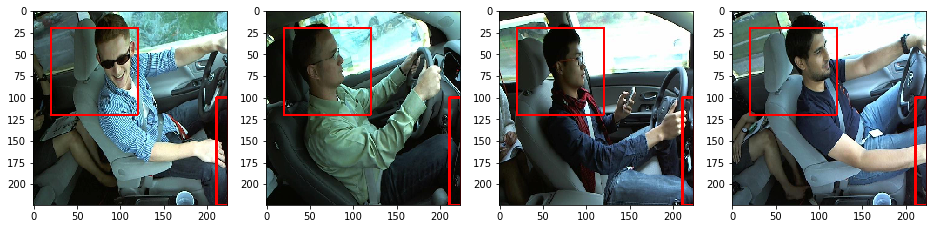

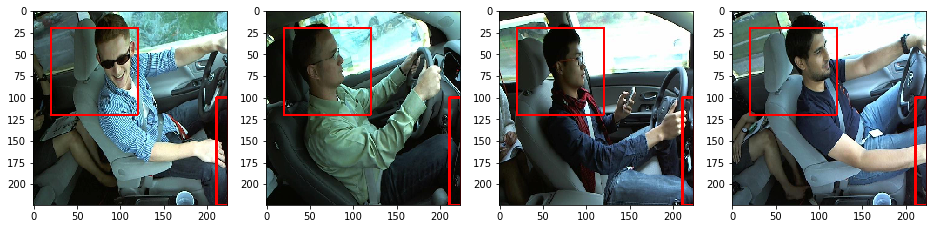

In [14]:
fig =plt.figure(figsize=(16,8))
for i in range(4):
    image_pre = np.squeeze(next(images))
    image_pre = preprocess_box(image_pre)
    
    ax = fig.add_subplot(1,4, i+1)
    ax.imshow((( image_pre+1)*125)/255)

### 3.1.2  预处理之边缘检测Sobel+Candy（无灰度图）

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


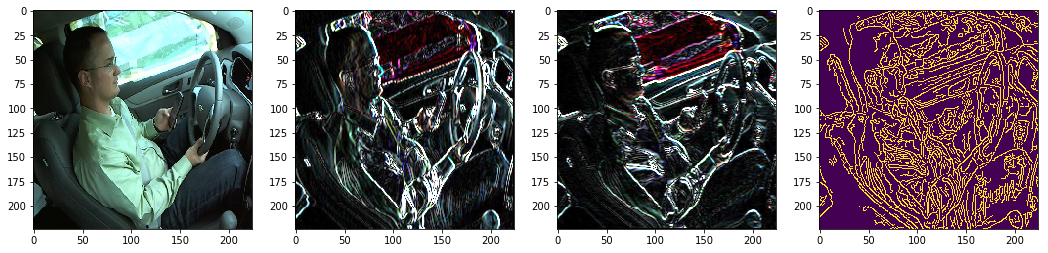

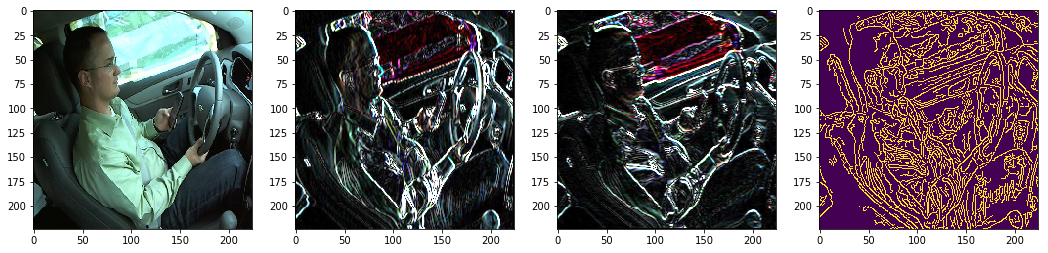

In [15]:
img = np.squeeze(next(images))
x = cv2.Sobel(np.squeeze(img),cv2.CV_16S,1,0)
y = cv2.Sobel(np.squeeze(img),cv2.CV_16S,0,1)
 
absX = cv2.convertScaleAbs(x)   # 转回uint8
absY = cv2.convertScaleAbs(y) 
# dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
# dst = cv2.cvtColor(dst,cv2.COLOR_RGB2GRAY,dst)
plt.figure(figsize=(18,16))
plt.subplot(141)
plt.imshow(img/255)
plt.subplot(142)
plt.imshow(absX/255)
plt.subplot(143)
plt.imshow(absY/255)
plt.subplot(144)
img = cv2.Canny(np.squeeze(img).astype(np.uint8),10,100)
plt.imshow(img)

# 4   创建自己的模型

In [12]:
def create_small_model_jump():
    """small size model """
    img_input = Input(shape=(224, 224, 3))
    # Block 1
    x = layers.Conv2D(64, (1, 1), activation='relu', padding='same', name='block0_conv0',
                      kernel_initializer="he_uniform")(img_input)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1',
                       kernel_initializer="he_uniform")(x)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2',
                       kernel_initializer="he_uniform")(x1)
    x = layers.Add()([x, x1])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (1, 1), activation='relu', padding='same', name='block2_conv0',
                      kernel_initializer="he_uniform")(x)
    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1',
                       kernel_initializer="he_uniform")(x)
    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2',
                       kernel_initializer="he_uniform")(x2)
    x = layers.Add()([x, x2])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same', name='block3_conv0',
                      kernel_initializer="he_uniform")(x)
    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1',
                       kernel_initializer="he_uniform")(x)
    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2',
                       kernel_initializer="he_uniform")(x3)
    x = layers.Add()([x, x3])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Global average pooling
    x = layers.GlobalAvgPool2D()(x)
    x = Dense(10, activation="softmax", kernel_initializer="he_uniform")(x)
    model = Model(inputs=img_input, outputs=x)

    return model

def create_small_model():
    """small size model """
    img_input = Input(shape=(224, 224, 3))
    # Block 1

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Global average pooling
    x = layers.GlobalAvgPool2D()(x)
    x = Dense(10, activation="softmax")(x)
    model = Model(inputs=img_input, outputs=x)

    return model

In [13]:
def run_model_fast(model_function, preprocessing_function,learning_rate=0.001,filename="submission.csv",epochs=8,
                   dir_name="vgg",batch_size=32):
    model = model_function
    train_gen,valid_gen,test_gen = get_batches(preprocessing_function=preprocessing_function,data_aug=False,
                                               class_mode="categorical",batch_size=batch_size)
    
    history = LossHistory()
    ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0,
                                                    mode='auto',
                                                    min_delta=0.0001, cooldown=0, min_lr=0.00001)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./{}/log".format(dir_name))
    
    time_start = datetime.now()
    
    model.compile(RMSprop(learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])
    model.fit_generator(train_gen,epochs=epochs,validation_data=valid_gen, callbacks=[tensorboard, history, ReduceLR])
    
    time_end = datetime.now()
    time_phase = (time_end-time_start).seconds
    print("训练用时{}秒".format(time_phase))
    
    model.save("./{}/model_{}.h5".format(dir_name, filename[:-4]))
    get_test_result(model,test_gen,filename=filename,dir_name=dir_name)
    
    del model
    gc.collect()
    
    return time_phase

In [46]:
run_model_fast(model_function=create_small_model, preprocessing_function=preprocess_edge_input,
               filename="submission_model_edge.csv",dir_name="small",batch_size=64,epochs=5)

In [ ]:
run_model_fast(model_function=create_small_model_jump, preprocessing_function=preprocess_edge_input,
               filename="submission_model_jump_edge.csv",dir_name="small",batch_size=64,epochs=5)

In [18]:
run_model_fast(model_function=create_small_model, preprocessing_function=preprocess_edge_gray_input,
               filename="submission_model_edge_gray.csv",dir_name="small",batch_size=64,epochs=5)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/5
320/320 [==============================] - 422s 1s/step - loss: 1.0787 - acc: 0.6610 - val_loss: 2.5958 - val_acc: 0.1510
Epoch 2/5
320/320 [==============================] - 224s 700ms/step - loss: 0.1574 - acc: 0.9639 - val_loss: 1.9457 - val_acc: 0.4455
Epoch 3/5
320/320 [==============================] - 224s 699ms/step - loss: 0.0584 - acc: 0.9855 - val_loss: 1.4419 - val_acc: 0.6150
Epoch 4/5
320/320 [==============================] - 224s 699ms/step - loss: 0.0312 - acc: 0.9924 - val_loss: 4.8859 - val_acc: 0.2990
Epoch 5/5
320/320 [==============================] - 224s 700ms/step - loss: 0.0050 - acc: 0.9994 - val_loss: 0.7968 - val_acc: 0.7585
训练用时1317秒


1317

In [ ]:
run_model_fast(model_function=create_small_model, preprocessing_function=preprocess_box,
               filename="submission_model_box.csv",dir_name="small",batch_size=64,epochs=5)

In [ ]:
run_model_fast(model_function=create_small_model, preprocessing_function=preprocess_mean_input,
               filename="submission_model_mean.csv",dir_name="small",batch_size=64,epochs=5)

In [ ]:
run_model_fast(model_function=create_small_model, preprocessing_function=preprocess_scaling_input,
               filename="submission_model_scaling.csv",dir_name="small",batch_size=64,epochs=5)

In [18]:
def class_activation_map(model,image_input):
    
    image_input_batch = next(image_input)
    #获取预测值
    index = np.argmax(model.predict(image_input_batch),-1)
    index_content = ["安全驾驶","右手打字","右手打电话","左手打字","左手打电话","调收音机",
                     "喝饮料","拿后面的东西","整理头发和化妆","和其他乘客说话"]
    #获取最后全连接层的权重，偏置不计
    layer_weights = model.layers[-1].get_weights()[0]
    
    # K.learning_phase()测试时为0，训练时为1
    get_gvp_layer_output = K.function([model.input, K.learning_phase()],[model.layers[-3].output])
    #获取最后一个卷积层的输出
    data = get_gvp_layer_output([image_input_batch, 0])[0]
    
    activation_map = np.squeeze(np.dot(data, layer_weights[:,index]))
#     activation_map = resize(activation_map,(224,224))
    activation_map = cv.resize(activation_map,(224,224))

    return image_input,activation_map,index_content[index[0]]

def plot_activation_map(image_input,model,num=2):
    
    fig = plt.figure(figsize=(16,6*num//2))
    
    for i in range(num):
        image_input, activation_map, index = class_activation_map(model,image_input)
        ax = fig.add_subplot(num//2,4, i*2+1)
        ax.suptitle("预测类别为:"+str(index),fontsize=20)
        ax.imshow(image_input)
        ax.add_subplot(num//2,4, i*2+2)
        ax.imshow(activation_map)

## 5  迁移学习

In [14]:
def create_vgg_finetune_model(finetune_model=VGG16(weights="/home/xiaolin/vgg16_weights.h5"), layer_n=1):
    """create vgg model for fine-tuning"""
    basic_model = finetune_model
    inputs = basic_model.input
    x = basic_model.layers[-2].output
    x = layers.Dense(10, activation="softmax", kernel_regularizer=l2(0.01))(x)
    model = Model(inputs=inputs, outputs=x)
    for i in model.layers:
        i.trainable = False
    for i in model.layers[layer_n:]:
        i.trainable = True
    return model

In [15]:
def create_vgg_drop( path="/home/xiaolin/vgg16_weights.h5"):
    """create vgg model with Batch Normalization"""
    img_input = Input(shape=(224, 224, 3))
    x = Convolution2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Convolution2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax', name='my_predictions')(x)

    model = Model(inputs=img_input, outputs=x)
    model.load_weights(path,by_name=True)
    
    return model

In [39]:
run_model_fast(model_function= create_vgg_finetune_model, learning_rate=0.0001,preprocessing_function=preprocess_edge_gray_input,
               filename="submission_vgg_edge_gray.csv",dir_name="vgg",batch_size=32,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/8
639/639 [==============================] - 319s 499ms/step - loss: 1.5160 - acc: 0.4817 - val_loss: 1.7782 - val_acc: 0.4965
Epoch 2/8
639/639 [==============================] - 312s 488ms/step - loss: 0.2007 - acc: 0.9482 - val_loss: 1.6611 - val_acc: 0.6980
Epoch 3/8
639/639 [==============================] - 311s 487ms/step - loss: 0.1139 - acc: 0.9757 - val_loss: 2.6636 - val_acc: 0.4970
Epoch 4/8
639/639 [==============================] - 311s 487ms/step - loss: 0.0274 - acc: 0.9949 - val_loss: 2.7779 - val_acc: 0.6220
Epoch 5/8
639/639 [==============================] - 311s 486ms/step - loss: 0.0110 - acc: 0.9987 - val_loss: 3.1088 - val_acc: 0.6315
Epoch 6/8
639/639 [==============================] - 311s 487ms/step - loss: 0.0069 - acc: 0.9995 - val_loss: 3.6090 - val_acc: 0.

2497

In [40]:
run_model_fast(model_function= create_vgg_finetune_model, learning_rate=0.0001,preprocessing_function=preprocess_edge_input,
               filename="submission_vgg_edge.csv",dir_name="vgg",batch_size=32,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/8
639/639 [==============================] - 316s 494ms/step - loss: 1.7571 - acc: 0.3936 - val_loss: 2.0454 - val_acc: 0.4915
Epoch 2/8
639/639 [==============================] - 312s 488ms/step - loss: 0.1763 - acc: 0.9501 - val_loss: 1.9587 - val_acc: 0.6035
Epoch 3/8
639/639 [==============================] - 311s 487ms/step - loss: 0.0892 - acc: 0.9785 - val_loss: 2.9325 - val_acc: 0.5010
Epoch 4/8
639/639 [==============================] - 311s 486ms/step - loss: 0.0207 - acc: 0.9964 - val_loss: 2.4108 - val_acc: 0.6215
Epoch 5/8
639/639 [==============================] - 311s 487ms/step - loss: 0.0096 - acc: 0.9988 - val_loss: 3.0079 - val_acc: 0.6140
Epoch 6/8
639/639 [==============================] - 311s 487ms/step - loss: 0.0057 - acc: 0.9994 - val_loss: 2.9945 - val_acc: 0.

2493

In [41]:
run_model_fast(model_function= create_vgg_finetune_model, learning_rate=0.0001,preprocessing_function=preprocess_box,
               filename="submission_vgg_box.csv",dir_name="vgg",batch_size=32,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/8
639/639 [==============================] - 313s 490ms/step - loss: 1.1281 - acc: 0.6182 - val_loss: 0.8385 - val_acc: 0.6755
Epoch 2/8
639/639 [==============================] - 309s 484ms/step - loss: 0.1340 - acc: 0.9679 - val_loss: 1.9133 - val_acc: 0.6115
Epoch 3/8
639/639 [==============================] - 309s 484ms/step - loss: 0.0242 - acc: 0.9962 - val_loss: 2.0373 - val_acc: 0.6695
Epoch 4/8
639/639 [==============================] - 309s 483ms/step - loss: 0.0124 - acc: 0.9986 - val_loss: 2.1861 - val_acc: 0.6865
Epoch 5/8
639/639 [==============================] - 309s 483ms/step - loss: 0.0068 - acc: 0.9993 - val_loss: 2.8813 - val_acc: 0.6840
Epoch 6/8
639/639 [==============================] - 309s 483ms/step - loss: 0.0036 - acc: 0.9997 - val_loss: 3.3877 - val_acc: 0.

2475

In [ ]:
run_model_fast(model_function= create_vgg_finetune_model, learning_rate=0.0001,preprocessing_function=preprocess_mean_input,
               filename="submission_vgg_mean.csv",dir_name="vgg",batch_size=32,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/8
639/639 [==============================] - 314s 491ms/step - loss: 1.0718 - acc: 0.6765 - val_loss: 5.0671 - val_acc: 0.4770
Epoch 2/8
639/639 [==============================] - 306s 479ms/step - loss: 0.2058 - acc: 0.9606 - val_loss: 1.0519 - val_acc: 0.7785
Epoch 3/8
639/639 [==============================] - 305s 478ms/step - loss: 0.1985 - acc: 0.9667 - val_loss: 1.2289 - val_acc: 0.7540
Epoch 4/8
639/639 [==============================] - 304s 476ms/step - loss: 0.0332 - acc: 0.9943 - val_loss: 1.1421 - val_acc: 0.7975
Epoch 5/8
639/639 [==============================] - 304s 476ms/step - loss: 0.0144 - acc: 0.9978 - val_loss: 1.8571 - val_acc: 0.7830
Epoch 6/8
639/639 [==============================] - 303s 475ms/step - loss: 0.0101 - acc: 0.9988 - val_loss: 2.1619 - val_acc: 0.

In [21]:
run_model_fast(model_function= create_vgg_finetune_model, learning_rate=0.0001,preprocessing_function=preprocess_edge_gray_input,
               filename="submission_vgg_edge_gray50.csv",dir_name="vgg",batch_size=52,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/8
393/393 [==============================] - 314s 799ms/step - loss: 2.0115 - acc: 0.3533 - val_loss: 2.5853 - val_acc: 0.4135
Epoch 2/8
393/393 [==============================] - 311s 792ms/step - loss: 0.3860 - acc: 0.9293 - val_loss: 1.9243 - val_acc: 0.6405
Epoch 3/8
393/393 [==============================] - 311s 791ms/step - loss: 0.1715 - acc: 0.9766 - val_loss: 2.0804 - val_acc: 0.5700
Epoch 4/8
393/393 [==============================] - 311s 791ms/step - loss: 0.0559 - acc: 0.9975 - val_loss: 1.8438 - val_acc: 0.6010
Epoch 5/8
393/393 [==============================] - 311s 791ms/step - loss: 0.0362 - acc: 0.9992 - val_loss: 1.9099 - val_acc: 0.6240
Epoch 6/8
393/393 [==============================] - 310s 790ms/step - loss: 0.0226 - acc: 0.9995 - val_loss: 2.0191 - val_acc: 0.

2489

In [32]:
run_model_fast(model_function= create_vgg_drop, learning_rate=0.0001,preprocessing_function=preprocess_edge_input,
               filename="submission_vgg_edge.csv",dir_name="vgg",batch_size=32,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/8
639/639 [==============================] - 315s 493ms/step - loss: 1.4826 - acc: 0.4692 - val_loss: 1.3468 - val_acc: 0.6585
Epoch 2/8
639/639 [==============================] - 311s 487ms/step - loss: 0.1913 - acc: 0.9465 - val_loss: 2.1877 - val_acc: 0.6380
Epoch 3/8
639/639 [==============================] - 311s 487ms/step - loss: 0.0244 - acc: 0.9934 - val_loss: 2.1529 - val_acc: 0.6420
Epoch 4/8
639/639 [==============================] - 311s 487ms/step - loss: 0.0099 - acc: 0.9975 - val_loss: 2.8427 - val_acc: 0.5980
Epoch 5/8
639/639 [==============================] - 310s 485ms/step - loss: 0.0047 - acc: 0.9987 - val_loss: 3.3932 - val_acc: 0.6465
Epoch 6/8
639/639 [==============================] - 309s 484ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 3.6990 - val_acc: 0.

2485

In [19]:
run_model_fast(model_function= create_vgg_drop(), learning_rate=0.0001,preprocessing_function=preprocess_edge_gray_input,
               filename="submission_vggdrop_edge_gray.csv",dir_name="vgg",batch_size=50,epochs=6)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/6
409/409 [==============================] - 324s 791ms/step - loss: 1.8047 - acc: 0.3404 - val_loss: 1.4574 - val_acc: 0.5375
Epoch 2/6
409/409 [==============================] - 314s 769ms/step - loss: 0.2089 - acc: 0.9372 - val_loss: 1.7264 - val_acc: 0.5810
Epoch 3/6
409/409 [==============================] - 312s 764ms/step - loss: 0.0222 - acc: 0.9944 - val_loss: 2.4017 - val_acc: 0.5935
Epoch 4/6
409/409 [==============================] - 314s 767ms/step - loss: 0.0112 - acc: 0.9973 - val_loss: 2.7639 - val_acc: 0.5935
Epoch 5/6
409/409 [==============================] - 313s 764ms/step - loss: 0.0058 - acc: 0.9984 - val_loss: 3.1297 - val_acc: 0.6125
Epoch 6/6
409/409 [==============================] - 312s 762ms/step - loss: 0.0035 - acc: 0.9993 - val_loss: 3.4538 - val_acc: 0.

1888

In [20]:
run_model_fast(model_function= create_vgg_drop(), learning_rate=0.0001,preprocessing_function=preprocess_mean_input,
               filename="submission_vggdrop_mean.csv",dir_name="vgg",batch_size=50,epochs=6)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/6
409/409 [==============================] - 323s 789ms/step - loss: 1.3949 - acc: 0.5145 - val_loss: 1.8219 - val_acc: 0.6180
Epoch 2/6
409/409 [==============================] - 311s 761ms/step - loss: 0.1982 - acc: 0.9553 - val_loss: 1.5015 - val_acc: 0.7315
Epoch 3/6
409/409 [==============================] - 311s 759ms/step - loss: 0.1663 - acc: 0.9677 - val_loss: 0.9991 - val_acc: 0.7865
Epoch 4/6
409/409 [==============================] - 309s 757ms/step - loss: 0.1497 - acc: 0.9762 - val_loss: 1.0354 - val_acc: 0.7520
Epoch 5/6
409/409 [==============================] - 309s 756ms/step - loss: 0.0278 - acc: 0.9943 - val_loss: 1.2927 - val_acc: 0.8400
Epoch 6/6
409/409 [==============================] - 309s 756ms/step - loss: 0.0121 - acc: 0.9980 - val_loss: 1.7037 - val_acc: 0.

1872

In [20]:
run_model_fast(model_function= create_vgg_finetune_model(finetune_model=ResNet50(weights=None), layer_n=1), learning_rate=0.0005,
               preprocessing_function=preprocess_mean_input,
               filename="submission_ResNet50_mean.csv",dir_name="vgg",batch_size=50,epochs=6)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/6
409/409 [==============================] - 254s 620ms/step - loss: 1.2342 - acc: 0.6565 - val_loss: 8.9842 - val_acc: 0.1145
Epoch 2/6
409/409 [==============================] - 244s 595ms/step - loss: 0.2000 - acc: 0.9636 - val_loss: 9.4607 - val_acc: 0.2230
Epoch 3/6
409/409 [==============================] - 243s 593ms/step - loss: 0.0533 - acc: 0.9969 - val_loss: 2.0200 - val_acc: 0.3925
Epoch 4/6
409/409 [==============================] - 243s 594ms/step - loss: 0.0248 - acc: 0.9994 - val_loss: 2.2164 - val_acc: 0.3630
Epoch 5/6
409/409 [==============================] - 243s 594ms/step - loss: 0.0142 - acc: 1.0000 - val_loss: 2.4396 - val_acc: 0.3675
Epoch 6/6
409/409 [==============================] - 243s 595ms/step - loss: 0.0111 - acc: 1.0000 - val_loss: 2.6289 - val_acc: 0.

1478

In [ ]:
run_model_fast(model_function= create_vgg_finetune_model(finetune_model=InceptionResNetV2(weights=None), layer_n=1), learning_rate=0.0005,
               preprocessing_function=preprocess_mean_input,
               filename="submission_InceptionResNetV2_mean.csv",dir_name="vgg",batch_size=32,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/8
639/639 [==============================] - 461s 722ms/step - loss: 0.4815 - acc: 0.8843 - val_loss: 3.4848 - val_acc: 0.3065
Epoch 2/8
639/639 [==============================] - 423s 662ms/step - loss: 0.1072 - acc: 0.9803 - val_loss: 1.8411 - val_acc: 0.5325
Epoch 3/8
639/639 [==============================] - 424s 663ms/step - loss: 0.0696 - acc: 0.9880 - val_loss: 1.7747 - val_acc: 0.5100
Epoch 4/8
639/639 [==============================] - 428s 670ms/step - loss: 0.0517 - acc: 0.9907 - val_loss: 2.4821 - val_acc: 0.3875
Epoch 5/8
639/639 [==============================] - 425s 665ms/step - loss: 0.0203 - acc: 0.9989 - val_loss: 0.6301 - val_acc: 0.8090
Epoch 6/8
639/639 [==============================] - 424s 664ms/step - loss: 0.0142 - acc: 0.9997 - val_loss: 0.6392 - val_acc: 0.

In [20]:
run_model_fast(model_function= create_vgg_finetune_model(finetune_model=InceptionResNetV2(weights=None), layer_n=1), learning_rate=0.0005,
               preprocessing_function=preprocess_edge_gray_input,
               filename="submission_InceptionResNetV2_gray.csv",dir_name="vgg",batch_size=50,epochs=6)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/6
409/409 [==============================] - 421s 1s/step - loss: 0.5911 - acc: 0.8531 - val_loss: 3.1079 - val_acc: 0.4075
Epoch 2/6
409/409 [==============================] - 391s 955ms/step - loss: 0.1162 - acc: 0.9807 - val_loss: 2.3192 - val_acc: 0.5605
Epoch 3/6
409/409 [==============================] - 392s 959ms/step - loss: 0.0649 - acc: 0.9900 - val_loss: 3.6911 - val_acc: 0.3465
Epoch 4/6
409/409 [==============================] - 392s 959ms/step - loss: 0.0225 - acc: 0.9989 - val_loss: 0.7989 - val_acc: 0.7355
Epoch 5/6
409/409 [==============================] - 392s 959ms/step - loss: 0.0146 - acc: 0.9999 - val_loss: 0.6774 - val_acc: 0.7730
Epoch 6/6
409/409 [==============================] - 392s 959ms/step - loss: 0.0117 - acc: 0.9999 - val_loss: 0.6434 - val_acc: 0.806

2384

In [21]:
run_model_fast(model_function= create_vgg_finetune_model(finetune_model=InceptionResNetV2(weights=None), layer_n=1), learning_rate=0.0005,
               preprocessing_function=preprocess_box,
               filename="submission_InceptionResNetV2_box.csv",dir_name="vgg",batch_size=50,epochs=8)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/6
409/409 [==============================] - 425s 1s/step - loss: 0.5132 - acc: 0.8807 - val_loss: 3.7181 - val_acc: 0.2350
Epoch 2/6
409/409 [==============================] - 389s 952ms/step - loss: 0.1077 - acc: 0.9825 - val_loss: 1.4394 - val_acc: 0.5570
Epoch 3/6
409/409 [==============================] - 392s 958ms/step - loss: 0.0620 - acc: 0.9896 - val_loss: 1.5809 - val_acc: 0.5800
Epoch 4/6
409/409 [==============================] - 390s 953ms/step - loss: 0.0216 - acc: 0.9991 - val_loss: 1.0235 - val_acc: 0.6795
Epoch 5/6
409/409 [==============================] - 390s 953ms/step - loss: 0.0137 - acc: 1.0000 - val_loss: 0.8976 - val_acc: 0.7080
Epoch 6/6
409/409 [==============================] - 389s 952ms/step - loss: 0.0116 - acc: 0.9999 - val_loss: 0.8437 - val_acc: 0.732

2386

In [19]:
# run_model_fast(model_function= create_vgg_finetune_model(finetune_model=DenseNet201(weights=None), layer_n=1), learning_rate=0.0005,
#                preprocessing_function=preprocess_mean_input,
#                filename="submission_DensNet_mean.csv", dir_name="vgg", batch_size=32, epochs=7)

In [18]:
run_model_fast(model_function= create_vgg_finetune_model(finetune_model=InceptionV3(weights=None), layer_n=1), learning_rate=0.0005,
               preprocessing_function=preprocess_mean_input,
               filename="submission_INception_mean.csv",dir_name="vgg",batch_size=32,epochs=6)

Reading train dataset
Found 20424 images belonging to 10 classes.
Reading valid dataset
Found 2000 images belonging to 10 classes.
Reading test dataset
Found 79726 images belonging to 1 classes.
Epoch 1/6
639/639 [==============================] - 205s 321ms/step - loss: 0.8894 - acc: 0.7450 - val_loss: 3.1302 - val_acc: 0.4450
Epoch 2/6
639/639 [==============================] - 193s 302ms/step - loss: 0.1932 - acc: 0.9534 - val_loss: 0.9727 - val_acc: 0.7730
Epoch 3/6
639/639 [==============================] - 195s 306ms/step - loss: 0.1195 - acc: 0.9745 - val_loss: 2.7540 - val_acc: 0.5665
Epoch 4/6
639/639 [==============================] - 194s 304ms/step - loss: 0.0474 - acc: 0.9930 - val_loss: 0.9206 - val_acc: 0.7255
Epoch 5/6
639/639 [==============================] - 195s 305ms/step - loss: 0.0306 - acc: 0.9967 - val_loss: 0.6417 - val_acc: 0.8310
Epoch 6/6
639/639 [==============================] - 195s 306ms/step - loss: 0.0214 - acc: 0.9984 - val_loss: 0.6850 - val_acc: 0.

1185

### 5.1 训练结果
结果来看，模型存在比较严重的过拟合，使用边缘检测+灰度图以及使用边框的效果较好一点  

模型|训练时长|预处理方式|训练集精度/验证集精度|训练集损失/验证集损失|Kaggle得分（Private）
-----|-----|-----|-----|-----|-----
VGG预训练|2497|边缘检测|0.9999/0.6320|0.0028/2.9895|2.17632
VGG预训练|2493|边缘检测+灰度图|0.9999/0.6440|0.0020/3.4252|2.27507
VGG预训练|2475|增加边框|0.9997/0.6475|0.00016/3.2976|1.43240
VGG预训练|2445|均值|0.992/0.7585|0.0063/2.0531|1.89149
VGGwithDropout|2485|边缘检测|0.9996/0.6150|0.0012/4.1580|2.17632
VGGwithDropout|2488|边缘检测+灰度图|0.9948/0.7255|0.0183/1.8571|1.34366
InceptionResNetV2|2384|均值|0.9999/0.8025|0.0117/0.6434|0.5360
InceptionV3|1185|均值|0.9984/0.8225|0.0214/0.6850|0.49177

## 多个模型集成
将自建模型、VGG、Inception以及InceptionResnet集成后的Kaggle得分（Public）约为0.38

## 6  交叉验证

save_data(dir_name='preprocess_data_edgegray', preprocessing_function=preprocess_edge_gray_input)

In [ ]:
import 

In [16]:
def create_inception_finetune_model(finetune_model=InceptionV3(weights=None), layer_n=1):
    """create vgg model for fine-tuning"""
    basic_model = finetune_model
    inputs = basic_model.input
    x = basic_model.layers[-2].output
    x = layers.Dense(10, activation="softmax", kernel_regularizer=l2(0.01))(x)
    model = Model(inputs=inputs, outputs=x)
    for i in model.layers:
        i.trainable = False
    for i in model.layers[layer_n:]:
        i.trainable = True
    return model

In [17]:
def run_cross_validate(model_function=create_small_model, learning_rate=0.001, driver_id=True,k_fold=5, epochs=12, 
                       dir_name="small_model", batch_size=32,optimizer=RMSprop, data_dir='preprocess_data_edgegray', 
                       preprocessing_function=preprocess_edge_gray_input):
    print("Reading train data")
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    # test
    # x,y = np.random.rand(10,224,224,3),np.random.rand(10,10)

    x, y = load_npy_data(data_dir)
    kf = KFold(n_splits=k_fold, random_state=10, shuffle=not driver_id)
    count_n = 0
    i = 0
    for train_index, valid_index in kf.split(x):
        if i > 1:
            losses = []
            accuracies = []
            vallosses = []
            valaccuracies = []
            print("getting {}hold sample".format(count_n + 1))
            x_train, x_valid = x[train_index], x[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
            print("Building model")
            model = model_function()
            print("内存地址{}".format(id(model)))
            model_compile(model, learning_rate=learning_rate, optimizer=optimizer)
            print("Start training")
            history = LossHistory()
            ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0,mode='auto',min_delta=0.0001, 
                                                            cooldown=0, min_lr=0.00001)
            tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./{}/log".format(dir_name))
            model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size,
                        callbacks=[tensorboard, history, ReduceLR])
            losses += history.losses
            accuracies += history.accuracies
            vallosses += history.vallosses
            valaccuracies += history.valaccuracies
            print("Saving loss and accuracy as npy")
            count_n += 1
            np.save("./{}/cv_loss{}.npy".format(dir_name, count_n), losses)
            np.save("./{}/cv_accuracy{}.npy".format(dir_name, count_n), accuracies)
            np.save("./{}/cv_valloss{}.npy".format(dir_name, count_n), vallosses)
            np.save("./{}/cv_valaccuracy{}.npy".format(dir_name, count_n), valaccuracies)

            model.save("./{}/model_{}.h5".format(dir_name, count_n))
            print("{} model completed".format(count_n))

            del model, history, ReduceLR, tensorboard, losses, accuracies, vallosses, valaccuracies, x_train, \
                x_valid, y_train, y_valid
            gc.collect()
        else:
            i = i+1
            count_n += 1


    del x, y
    gc.collect()

    print("starting predicting")
    # test_gen = np.random.rand(10, 224, 224, 3)
    test_gen = get_test_batches( batch_size=batch_size,preprocessing_function=preprocessing_function)
    result_mean = 0
    for i in range(k_fold):
        model = load_model("./{}/model_{}.h5".format(dir_name, i + 1))
        print("load model successfully")
        # result_predict = model.predict(test_gen)  # test
        result_predict = model.predict_generator(test_gen)
        pd.DataFrame(result_predict, columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"]).\
            to_csv("./{}/cross_validate{}.csv".format(dir_name,i+1))
        result_mean += np.array(result_predict)
        del model
        gc.collect()
        print("Progress status : {:.0f}%".format((i * 100 + 100) / k_fold))
    # print(result_mean)  # test
    result_mean /= k_fold
    # print(result_mean)  # test
    file_names = [re.search(r"img.+\.jpg", i).group(0) for i in test_gen.filenames]

    result = pd.DataFrame(file_names, columns=["img"])
    result_pro = pd.DataFrame(result_mean, columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])
    result_csv = result.join(result_pro)
    result_csv.to_csv("./{}/cross_validate.csv".format(dir_name))
    print("Prediction finished")

In [18]:
def model_compile(model, learning_rate=0.001, optimizer=RMSprop):
    model.compile(optimizer(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

<font color=red> **由于网络不是十分稳定会存在个人Windows平台下的Jupyter无法连接到服务器的jupyter，训练过程的显示不完整！！！**</font>

In [ ]:
run_cross_validate(model_function=create_small_model, learning_rate=0.001, driver_id=True,k_fold=8, epochs=6, dir_name="small_model", 
                   batch_size=64,optimizer=RMSprop, batch_learningrate=False,data_dir='preprocess_data_edgegray')

In [ ]:
 dir_name="small_model"
k_fold = 8
print("starting predicting")
    # test_gen = np.random.rand(10, 224, 224, 3)
test_gen = get_test_batches( batch_size=32,preprocessing_function=preprocess_edge_gray_input)
result_mean = 0
for i in range(k_fold):
    model = load_model("./{}/model_{}.h5".format(dir_name, i + 1))
    print("load model successfully")
    # result_predict = model.predict(test_gen)  # test
    result_predict = model.predict_generator(test_gen)
    pd.DataFrame(result_predict, columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"]).\
        to_csv("./{}/cross_validate{}.csv".format(dir_name,i+1))
    result_mean += np.array(result_predict)
    del model
    gc.collect()
    print("Progress status : {:.0f}%".format((i * 100 + 100) / k_fold))
# print(result_mean)  # test
result_mean /= k_fold
# print(result_mean)  # test
file_names = [re.search(r"img.+\.jpg", i).group(0) for i in test_gen.filenames]

result = pd.DataFrame(file_names, columns=["img"])
result_pro = pd.DataFrame(result_mean, columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])
result_csv = result.join(result_pro)
result_csv.to_csv("./{}/cross_validate.csv".format(dir_name))
print("Prediction finished")

starting predicting
Reading test dataset
Found 79726 images belonging to 1 classes.
load model successfully
Progress status : 1%
load model successfully


In [41]:
ensemble_8=0
for i in range(8):
    a = pd.read_csv(r"/home/xiaolin/small_model/cross_validate{}.csv".format(i+1))
    ensemble_8 += a
ensemble_8/=8


In [42]:
ensemble_8.iloc[:,0]=  [re.search(r"img.+\.jpg", i).group(0) for i in test_gen.filenames]

In [43]:
b = ensemble_8.rename(columns={"Unnamed: 0":"img"})

In [44]:
b.to_csv("cross_8.csv")

In [45]:
b

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,8.671208e-04,1.620275e-05,5.517896e-05,1.353730e-02,1.651171e-05,9.853634e-01,4.742371e-05,7.302958e-05,5.575038e-06,1.831232e-05
1,img_10.jpg,1.212740e-04,1.322616e-07,4.718515e-08,1.149876e-06,1.699386e-07,9.996451e-01,8.817403e-07,5.097772e-05,7.784194e-07,1.795329e-04
2,img_100.jpg,9.577091e-01,2.197457e-02,2.349888e-07,1.029164e-05,1.239118e-07,2.874648e-07,1.969471e-05,7.226027e-06,2.608041e-06,2.027592e-02
3,img_1000.jpg,7.640249e-08,5.487098e-09,3.068307e-06,2.596186e-11,6.640451e-09,1.824806e-07,1.735554e-03,6.841741e-08,9.982609e-01,1.331346e-07
4,img_100000.jpg,1.105200e-02,1.845362e-05,2.579234e-06,9.320644e-01,1.322656e-04,2.997541e-02,2.162766e-04,4.315523e-06,1.900084e-04,2.634434e-02
5,img_100001.jpg,1.111286e-05,5.295996e-06,3.912010e-07,9.995956e-01,2.833015e-04,1.372324e-06,7.730169e-07,1.060281e-07,7.798574e-05,2.408833e-05
6,img_100002.jpg,5.471551e-08,1.784073e-06,9.471220e-09,1.224700e-07,1.064503e-09,1.401137e-07,1.951776e-05,4.264859e-06,9.999732e-01,8.645442e-07
7,img_100003.jpg,9.183615e-01,1.250225e-02,9.428088e-05,1.929081e-03,2.583831e-04,1.707917e-02,2.487144e-02,6.533366e-04,7.654309e-03,1.659624e-02
8,img_100004.jpg,1.288240e-08,2.054264e-08,1.906442e-05,9.286701e-11,8.891492e-13,6.244551e-08,9.999760e-01,5.502643e-10,4.173768e-06,7.125738e-07
9,img_100005.jpg,2.577990e-06,2.188926e-05,1.376022e-05,2.479797e-06,1.042154e-06,2.327227e-04,5.713572e-03,9.449181e-01,1.666371e-04,4.892720e-02


In [20]:
save_data(dir_name='preprocess_data_box', preprocessing_function=preprocess_box)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
 The program has processed 100%

In [22]:
run_cross_validate(model_function= create_inception_finetune_model, learning_rate=0.0004, 
                   driver_id=True,k_fold=10, epochs=10, 
                   dir_name="Inceptionv3", batch_size=56,optimizer=RMSprop, data_dir='preprocess_data', 
                   preprocessing_function=preprocess_mean_input)

Reading train data
getting 3hold sample
Building model
内存地址140258473254304
Start training
Train on 17159 samples, validate on 1907 samples
Epoch 1/10
17159/17159 [==============================] - 153s 9ms/step - loss: 0.9867 - acc: 0.7338 - val_loss: 4.9774 - val_acc: 0.3702
Epoch 2/10
17159/17159 [==============================] - 141s 8ms/step - loss: 0.2272 - acc: 0.9482 - val_loss: 3.2707 - val_acc: 0.5941
Epoch 3/10
17159/17159 [==============================] - 141s 8ms/step - loss: 0.1305 - acc: 0.9713 - val_loss: 0.9668 - val_acc: 0.7347
Epoch 4/10
17159/17159 [==============================] - 140s 8ms/step - loss: 0.0929 - acc: 0.9807 - val_loss: 2.0716 - val_acc: 0.5045
Epoch 5/10
17159/17159 [==============================] - 140s 8ms/step - loss: 0.0779 - acc: 0.9840 - val_loss: 1.5905 - val_acc: 0.6649
Epoch 6/10
17159/17159 [==============================] - 140s 8ms/step - loss: 0.0324 - acc: 0.9957 - val_loss: 0.5241 - val_acc: 0.8899
Epoch 7/10
17159/17159 [=========

In [ ]:
run_cross_validate(model_function=create_vgg_drop(), learning_rate=0.001, driver_id=True,k_fold=13, epochs=8, dir_name="vggl_drop", 
                   batch_size=64,optimizer=RMSprop, batch_learningrate=False,data_dir='preprocess_data_box')

In [27]:
def run_cross_validate2(model_function=create_small_model, learning_rate=0.001, driver_id=True,k_fold=5, epochs=12, 
                       dir_name="small_model", batch_size=32,optimizer=RMSprop, data_dir='preprocess_data_edgegray', 
                       preprocessing_function=preprocess_edge_gray_input):
    print("Reading train data")
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    # test
    # x,y = np.random.rand(10,224,224,3),np.random.rand(10,10)

#     x, y = load_npy_data(data_dir)
    x = np.arange(1000)
    kf = KFold(n_splits=k_fold, random_state=10, shuffle=not driver_id)
    count_n = 0
    i = 0
    for train_index, valid_index in kf.split(x):
        if i > -1:
            losses = []
            accuracies = []
            vallosses = []
            valaccuracies = []
            print("getting {}hold sample".format(count_n + 1))
            train_gen,valid_gen,test_gen = get_batches(preprocessing_function=preprocessing_function,data_aug=False,
                                                       class_mode="categorical",batch_size=batch_size)
#             x_train, x_valid = x[train_index], x[valid_index]
#             y_train, y_valid = y[train_index], y[valid_index]
            print("Building model")
            model = model_function()
            print("内存地址{}".format(id(model)))
            print(model.layers[-1].get_weights()[0][0])
            model_compile(model, learning_rate=learning_rate, optimizer=optimizer)
            print("Start training")
#             history = LossHistory()
#             ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0,mode='auto',min_delta=0.0001, 
#                                                             cooldown=0, min_lr=0.00001)
#             tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./{}/log".format(dir_name))
#             model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=None,steps_per_epoch=10)
            model.fit_generator(train_gen,epochs=1,steps_per_epoch=10)
            print(model.layers[-1].get_weights()[0][0])
#             losses += history.losses
#             accuracies += history.accuracies
#             vallosses += history.vallosses
#             valaccuracies += history.valaccuracies
#             print("Saving loss and accuracy as npy")
#             count_n += 1
#             np.save("./{}/cv_loss{}.npy".format(dir_name, count_n), losses)
#             np.save("./{}/cv_accuracy{}.npy".format(dir_name, count_n), accuracies)
#             np.save("./{}/cv_valloss{}.npy".format(dir_name, count_n), vallosses)
#             np.save("./{}/cv_valaccuracy{}.npy".format(dir_name, count_n), valaccuracies)

#             model.save("./{}/model_{}.h5".format(dir_name, count_n))
#             print("{} model completed".format(count_n))

#             del model, history, ReduceLR, tensorboard, losses, accuracies, vallosses, valaccuracies, x_train, \
#                 x_valid, y_train, y_valid
#             gc.collect()
        else:
            i = i+1
            count_n += 1


#     del x, y
#     gc.collect()

#     print("starting predicting")
#     # test_gen = np.random.rand(10, 224, 224, 3)
#     test_gen = get_test_batches( batch_size=batch_size,preprocessing_function=preprocessing_function)
#     result_mean = 0
#     for i in range(k_fold):
#         model = load_model("./{}/model_{}.h5".format(dir_name, i + 1))
#         print("load model successfully")
#         # result_predict = model.predict(test_gen)  # test
#         result_predict = model.predict_generator(test_gen)
#         pd.DataFrame(result_predict, columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"]).\
#             to_csv("./{}/cross_validate{}.csv".format(dir_name,i+1))
#         result_mean += np.array(result_predict)
#         del model
#         gc.collect()
#         print("Progress status : {:.0f}%".format((i * 100 + 100) / k_fold))
#     # print(result_mean)  # test
#     result_mean /= k_fold
#     # print(result_mean)  # test
#     file_names = [re.search(r"img.+\.jpg", i).group(0) for i in test_gen.filenames]

#     result = pd.DataFrame(file_names, columns=["img"])
#     result_pro = pd.DataFrame(result_mean, columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])
#     result_csv = result.join(result_pro)
#     result_csv.to_csv("./{}/cross_validate.csv".format(dir_name))
    print("Prediction finished")